In [2]:
!pip install -q kaggle

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"bloga1","key":"959954f5d3a381be9b1425c8fd63cf4f"}'}

In [4]:
! mkdir ~/.kaggle

In [5]:
! cp kaggle.json ~/.kaggle/

In [6]:
! chmod 600 ~/.kaggle/kaggle.json

In [7]:
! kaggle datasets download -d mczielinski/bitcoin-historical-data

 93% 93.0M/100M [00:01<00:00, 130MB/s]
100% 100M/100M [00:01<00:00, 94.8MB/s]


In [8]:
! unzip /content/bitcoin-historical-data.zip

Archive:  /content/bitcoin-historical-data.zip
  inflating: bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv  


In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import r2_score


In [10]:
# Resampling data from minute interval to day
bit_df = pd.read_csv('/content/bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv')
bit_df.head(10)

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
1,1325317980,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1325318040,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1325318100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1325318160,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1325318220,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,1325318280,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,1325318340,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,1325318400,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,1325318460,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
bit_df.tail()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
4857372,1617148560,58714.31,58714.31,58686.00,58686.00,1.384487,81259.372187,58692.753339
4857373,1617148620,58683.97,58693.43,58683.97,58685.81,7.294848,428158.146640,58693.226508
4857374,1617148680,58693.43,58723.84,58693.43,58723.84,1.705682,100117.070370,58696.198496
4857375,1617148740,58742.18,58770.38,58742.18,58760.59,0.720415,42332.958633,58761.866202
4857376,1617148800,58767.75,58778.18,58755.97,58778.18,2.712831,159417.751000,58764.349363


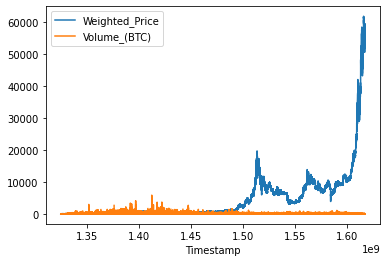

In [12]:
bit_df.plot(x='Timestamp',y=['Weighted_Price','Volume_(BTC)'])
plt.show()

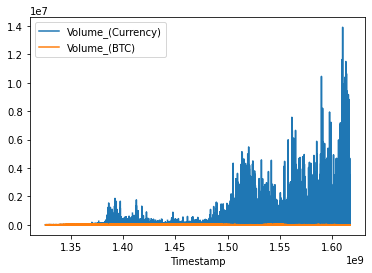

In [13]:
bit_df.plot(x='Timestamp',y=['Volume_(Currency)','Volume_(BTC)'])
plt.show()

In [17]:
# Convert unix time to datetime
bit_df['date'] = pd.to_datetime(bit_df.Timestamp, unit='s')
# Reset index
bit_df = bit_df.set_index('date')
# Resample and only use recent samples that aren't missing
bit_df = bit_df.resample('d').agg({'Open': 'first', 'High': 'max', 
    'Low': 'min', 'Close': 'last', 'Volume_(BTC)': 'sum',
    'Volume_(Currency)': 'sum', 'Weighted_Price': 'mean', 'Timestamp': 'min'}).iloc[-1000:]
# drop last row as it is not complete
bit_df = bit_df.iloc[:-1]

In [18]:
bit_df.shape

(999, 8)

In [19]:
bit_df.head()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,Timestamp
date,,,,,,,,
2018-07-06,6533.69,6636.15,6449.76,6596.53,5457.672187,3.571456e+07,6541.718841,1.530835e+09
2018-07-07,6604.74,6820.00,6510.00,6759.99,4842.795871,3.203913e+07,6573.830823,1.530922e+09
2018-07-08,6755.46,6783.54,6674.60,6706.60,5145.845757,3.467398e+07,6738.872118,1.531008e+09
2018-07-09,6706.60,6814.72,6620.00,6666.75,7165.217233,4.805847e+07,6705.525899,1.531094e+09
2018-07-10,6666.75,6683.90,6270.84,6299.46,9163.019775,5.907961e+07,6480.199576,1.531181e+09


In [20]:
bit_df.tail()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,Timestamp
date,,,,,,,,
2021-03-26,51292.65,55114.86,51263.38,55081.37,4874.251115,2.599110e+08,53241.037489,1.616717e+09
2021-03-27,55081.26,56686.15,53948.35,55839.42,2609.967580,1.443661e+08,55193.357260,1.616803e+09
2021-03-28,55817.85,56573.04,54677.51,55790.92,2073.449191,1.154652e+08,55832.958824,1.616890e+09
2021-03-29,55790.28,58402.68,54892.42,57600.10,5360.425663,3.069515e+08,56913.993819,1.616976e+09
2021-03-30,57623.66,59388.66,57011.00,58760.59,3392.338619,1.983618e+08,58346.912268,1.617062e+09


In [21]:
bit_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 999 entries, 2018-07-06 to 2021-03-30
Freq: D
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Open               999 non-null    float64
 1   High               999 non-null    float64
 2   Low                999 non-null    float64
 3   Close              999 non-null    float64
 4   Volume_(BTC)       999 non-null    float64
 5   Volume_(Currency)  999 non-null    float64
 6   Weighted_Price     999 non-null    float64
 7   Timestamp          999 non-null    float64
dtypes: float64(8)
memory usage: 70.2 KB


In [22]:
bit_df.describe()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,Timestamp
count,999.000000,999.000000,999.000000,999.000000,999.000000,9.990000e+02,999.000000,9.990000e+02
mean,11798.002773,12161.015365,11421.939990,11849.671091,8361.949983,9.956382e+07,11811.975339,1.573949e+09
std,11311.308236,11776.056953,10831.341291,11406.764638,6174.608351,1.288373e+08,11340.826460,2.492906e+07
min,3180.840000,3230.000000,3122.280000,3179.540000,839.297665,5.373482e+06,3179.059337,1.530835e+09
25%,6433.470000,6557.550000,6341.865000,6433.140000,4432.651160,3.199725e+07,6435.892379,1.552392e+09
50%,8715.350000,8895.000000,8507.930000,8717.960000,6750.772194,5.686382e+07,8698.505459,1.573949e+09
75%,10791.180000,11048.055000,10550.625000,10808.260000,10081.770168,1.089868e+08,10749.532427,1.595506e+09
max,61177.030000,61781.830000,58959.570000,61165.190000,58513.389189,1.369434e+09,60455.844831,1.617062e+09


In [23]:
bit_df.corr()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,Timestamp
Open,1.000000,0.999070,0.998427,0.998080,0.015359,0.701755,0.999337,0.654078
High,0.999070,1.000000,0.998402,0.999227,0.028722,0.713467,0.999608,0.653031
Low,0.998427,0.998402,1.000000,0.998874,-0.005500,0.679788,0.999435,0.656192
Close,0.998080,0.999227,0.998874,1.000000,0.013645,0.700663,0.999300,0.654895
Volume_(BTC),0.015359,0.028722,-0.005500,0.013645,1.000000,0.538398,0.013175,0.027939
Volume_(Currency),0.701755,0.713467,0.679788,0.700663,0.538398,1.000000,0.698219,0.490290
Weighted_Price,0.999337,0.999608,0.999435,0.999300,0.013175,0.698219,1.000000,0.654530
Timestamp,0.654078,0.653031,0.656192,0.654895,0.027939,0.490290,0.654530,1.000000


In [25]:
full_x = bit_df[['High', 'Low', 'Close', 'Volume_(BTC)', 'Volume_(Currency)', 'Weighted_Price', 'Timestamp']]
full_y = bit_df['Open']

In [26]:
full_x_train, full_x_test, full_y_train, full_t_test = train_test_split(full_x, full_y, random_state = 2)

In [27]:
scaler = StandardScaler()
full_x_train = scaler.fit_transform(full_x_train)
full_x_test = scaler.transform(full_x_test)

In [29]:
full_x_train.shape

(749, 7)

In [28]:
x_train = full_x_train[:, 6]
x_test = full_x_test[:, 6]
y_train = full_y_train
y_test = full_t_test

In [30]:
model = LinearRegression()
x_train = x_train.reshape(-1, 1)
model.fit(x_train, y_train)

LinearRegression()

In [31]:
x_test = x_test.reshape(-1, 1)
predicted = model.predict(x_test)

In [32]:
mae(predicted, y_test)

5564.889184001748

In [33]:
r2 = r2_score(y_test, predicted)
r2

0.4185335113045664

In [34]:
x_test.shape

(250, 1)

In [35]:
adjusted_r2 = 1 - ((1 - r2)*(x_test.shape[0] - 1)/(x_test.shape[0] - x_test.shape[1] - 1))

In [36]:
adjusted_r2

0.4161888883662783

In [38]:
full_x = bit_df[['Open','High', 'Low', 'Close', 'Volume_(BTC)', 'Volume_(Currency)', 'Weighted_Price', 'Timestamp']]
full_y = bit_df['Close']

In [39]:
full_x.shape

(999, 8)

In [40]:
full_y.shape

(999,)

In [41]:
full_x = full_x.iloc[:998, :]    # we are taking all rows except the last as the feature
full_y = full_y[1:] 

In [42]:
full_x.shape

(998, 8)

In [43]:
full_y.shape

(998,)

In [44]:
x_train, x_test, y_train, y_test = train_test_split(full_x, full_y, random_state = 2)

In [45]:
scaler = StandardScaler()
X_train = scaler.fit_transform(x_train)
X_test = scaler.transform(x_test)

In [46]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [47]:
predicted = model.predict(X_test)
mae(predicted, y_test)

360.7586577137036

In [48]:
r2 = r2_score(y_test, predicted)
r2

0.9956468635317113

In [49]:
X_test.shape

(250, 8)

In [50]:
adjusted_r2 = 1 - ((1 - r2)*(X_test.shape[0] - 1)/(X_test.shape[0] - X_test.shape[1] - 1))
adjusted_r2

0.9955023610763324

In [51]:
scaler = StandardScaler()
X_train = scaler.fit_transform(full_x)
data = scaler.transform(bit_df.iloc[-2:])

In [52]:
model = LinearRegression()
model.fit(X_train, full_y)

LinearRegression()

In [53]:
data

array([[ 3.92573709,  3.96286643,  4.05379231,  4.04943045, -0.48707236,
         1.61093085,  4.01511964,  1.73031615],
       [ 4.08917176,  4.04727759,  4.25115079,  4.15204151, -0.80591472,
         0.76783825,  4.14255068,  1.7337872 ]])

In [54]:
y = model.predict(data)

In [55]:
full_y[-1]

58760.59

In [56]:
y[-2]

57717.43696287656

In [57]:
y[-1]

59365.249452501426